<a href="https://colab.research.google.com/github/ZhengTzer/machinelearningcourse/blob/master/Week03%20-%20Fraudulent%20Prediction/Week03_ieee_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression  
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data outline

In [0]:
df_train_iden = pd.read_csv("/content/drive/My Drive/Siraj/Week03-fraud-detection/ieee-fraud-detection/train_identity.csv")
df_train_tran = pd.read_csv("/content/drive/My Drive/Siraj/Week03-fraud-detection/ieee-fraud-detection/train_transaction.csv")

In [23]:
df_train_iden.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [24]:
df_train_tran.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
df = pd.merge(df_train_iden, df_train_tran, on='TransactionID', how='left')
df.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,...,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,...,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,...,1.0,1.0,1.0,1.0,1.0,1.0,166.215393,166.215393,166.215393,90.327904,90.327904,31.841299,90.327904,90.327904,90.327904,90.327904,0.0,0.0,0.0,75.887497,75.887497,75.887497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,...,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,...,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
fraud = df.loc[df['isFraud'] == 1]
non_frauds = df.loc[df['isFraud'] == 0]

In [27]:
normal_transacation = len(df[df["isFraud"]==0])/(len(df[df["isFraud"]==0]) + len(df[df["isFraud"]==1]))
print("Normal Transacation:",normal_transacation*100,"%")
fraud_transacation= len(df[df["isFraud"]==1])/( len(df[df["isFraud"]==1]) + len(df[df["isFraud"]==0]))
print("Fraud transacation:",fraud_transacation*100, '%')

Normal Transacation: 92.15297470065796 %
Fraud transacation: 7.847025299342036 %


# EDA 1 - Fraud Behaviour on mobile vs desktop
(why mobile, i assume desktop is easier to conduct fraud, interesting)

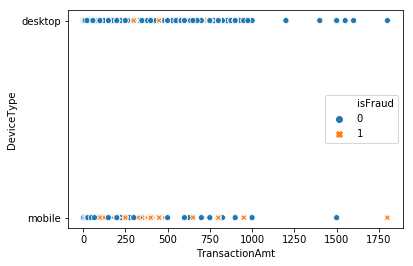

In [28]:
ax = sns.scatterplot(x="TransactionAmt", y="DeviceType", hue='isFraud', style="isFraud", data=df)
plt.show()

In [29]:
#percentage of fraud conduct on mobile
fraud_on_mobi = df.loc[df['DeviceType'] == 'mobile']
fraud_on_mobi_percent = len(fraud_on_mobi[df["isFraud"]==1])/(len(fraud_on_mobi[df["isFraud"]==0]) + len(fraud_on_mobi[df["isFraud"]==1]))
print("Fraud transaction on mobile:",fraud_on_mobi_percent*100, '%')

Fraud transaction on mobile: 10.166232365890917 %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [30]:
#percentage of fraud conduct on pc
fraud_on_desk = df.loc[df['DeviceType'] == 'desktop']
fraud_on_desk_percent = len(fraud_on_desk[df["isFraud"]==1])/(len(fraud_on_desk[df["isFraud"]==0]) + len(fraud_on_desk[df["isFraud"]==1]))
print("Fraud transaction on desktop:",fraud_on_desk_percent*100, '%')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Fraud transaction on desktop: 6.521458345564493 %


# Feature and Cleaning

In [0]:
columns_def = pd.DataFrame({"na_count":df.isnull().sum().sort_values(ascending=False)})
columns_def["per"] = columns_def["na_count"]/len(df)

In [32]:
range=[0.1 ,0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in range: 
    print (columns_def[columns_def["per"]<i].shape[0]/df.shape[1])

0.5622119815668203
0.5691244239631337
0.5691244239631337
0.5691244239631337
0.7027649769585254
0.9170506912442397
0.9193548387096774
0.9308755760368663
0.9308755760368663


In [33]:
limit = 0.1
columns_final=columns_def[columns_def["per"]<limit].index
df = df[df.columns.intersection(columns_final)]
df[df.select_dtypes(include=['object']).columns].head()

,id_12,id_15,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,ProductCD,card4,card6,P_emaildomain,R_emaildomain
0,NotFound,New,New,NotFound,samsung browser 6.2,T,F,T,T,mobile,H,mastercard,credit,gmail.com,NaN
1,NotFound,New,New,NotFound,mobile safari 11.0,T,F,F,T,mobile,H,visa,debit,anonymous.com,NaN
2,NotFound,Found,Found,Found,chrome 62.0,F,F,T,T,desktop,C,mastercard,credit,gmail.com,gmail.com
3,NotFound,New,New,NotFound,chrome 62.0,F,F,T,T,desktop,C,mastercard,debit,hotmail.com,hotmail.com
4,NotFound,Found,Found,Found,chrome 62.0,T,F,T,T,desktop,H,visa,debit,aol.com,NaN


In [0]:
DeviceType_dummy_df = pd.get_dummies(df["DeviceType"])
card4_dummy_df = pd.get_dummies(df["card4"])
card6_dummy_df = pd.get_dummies(df["card6"])

In [35]:
df = pd.concat([df,DeviceType_dummy_df ,card4_dummy_df ,card6_dummy_df],axis=1)
df.head()

,TransactionID,id_01,id_02,id_05,id_06,id_11,id_12,id_15,id_17,id_19,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,desktop,mobile,american express,discover,mastercard,visa,charge card,credit,debit
0,2987004,0.0,70787.0,NaN,NaN,100.0,NotFound,New,166.0,542.0,144.0,New,NotFound,samsung browser 6.2,T,F,T,T,mobile,0,86506,50.000,H,4497,514.0,150.0,mastercard,102.0,credit,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,1,0,0,1,0,0,1,0
1,2987008,-5.0,98945.0,0.0,-5.0,100.0,NotFound,New,166.0,621.0,500.0,New,NotFound,mobile safari 11.0,T,F,F,T,mobile,0,86535,15.000,H,2803,100.0,150.0,visa,226.0,debit,anonymous.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,1,0,0,0,1,0,0,1
2,2987010,-5.0,191631.0,0.0,0.0,100.0,NotFound,Found,121.0,410.0,142.0,Found,Found,chrome 62.0,F,F,T,T,desktop,0,86549,75.887,C,16496,352.0,117.0,mastercard,134.0,credit,gmail.com,gmail.com,1.0,4.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,...,4.0,4.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,166.215393,166.215393,166.215393,90.327904,90.327904,31.841299,90.327904,90.327904,90.327904,90.327904,0.0,0.0,0.0,75.887497,75.887497,75.887497,1,0,0,0,1,0,0,1,0
3,2987011,-5.0,221832.0,0.0,-6.0,100.0,NotFound,New,225.0,176.0,507.0,New,NotFound,chrome 62.0,F,F,T,T,desktop,0,86555,16.495,C,4461,375.0,185.0,mastercard,224.0,debit,hotmail.com,hotmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,1,0,0,0,1,0,0,0,1
4,2987016,0.0,7460.0,1.0,0.0,100.0,NotFound,Found,166.0,529.0,575.0,Found,Found,chrome 62.0,T,F,T,T,desktop,0,86620,30.000,H,1790,555.0,150.0,visa,226.0,debit,aol.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,1,0,0,0,0,1,0,0,1


In [36]:
#drop unnesscary dummy: desktop column(1 = desktop, 0 = mobile); credit column(1 = creditcard, 0 = debitcard)
df.drop(['mobile', 'debit'], axis=1, inplace=True)
df.head()

,TransactionID,id_01,id_02,id_05,id_06,id_11,id_12,id_15,id_17,id_19,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,desktop,american express,discover,mastercard,visa,charge card,credit
0,2987004,0.0,70787.0,NaN,NaN,100.0,NotFound,New,166.0,542.0,144.0,New,NotFound,samsung browser 6.2,T,F,T,T,mobile,0,86506,50.000,H,4497,514.0,150.0,mastercard,102.0,credit,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,1,0,0,1
1,2987008,-5.0,98945.0,0.0,-5.0,100.0,NotFound,New,166.0,621.0,500.0,New,NotFound,mobile safari 11.0,T,F,F,T,mobile,0,86535,15.000,H,2803,100.0,150.0,visa,226.0,debit,anonymous.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0
2,2987010,-5.0,191631.0,0.0,0.0,100.0,NotFound,Found,121.0,410.0,142.0,Found,Found,chrome 62.0,F,F,T,T,desktop,0,86549,75.887,C,16496,352.0,117.0,mastercard,134.0,credit,gmail.com,gmail.com,1.0,4.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,...,2.0,4.0,4.0,4.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,166.215393,166.215393,166.215393,90.327904,90.327904,31.841299,90.327904,90.327904,90.327904,90.327904,0.0,0.0,0.0,75.887497,75.887497,75.887497,1,0,0,1,0,0,1
3,2987011,-5.0,221832.0,0.0,-6.0,100.0,NotFound,New,225.0,176.0,507.0,New,NotFound,chrome 62.0,F,F,T,T,desktop,0,86555,16.495,C,4461,375.0,185.0,mastercard,224.0,debit,hotmail.com,hotmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,1,0,0,1,0,0,0
4,2987016,0.0,7460.0,1.0,0.0,100.0,NotFound,Found,166.0,529.0,575.0,Found,Found,chrome 62.0,T,F,T,T,desktop,0,86620,30.000,H,1790,555.0,150.0,visa,226.0,debit,aol.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,1,0,0,0,1,0,0


In [37]:
df['TransactionAmt'] = MinMaxScaler().fit_transform(df[['TransactionAmt']])
df.head()

,TransactionID,id_01,id_02,id_05,id_06,id_11,id_12,id_15,id_17,id_19,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,desktop,american express,discover,mastercard,visa,charge card,credit
0,2987004,0.0,70787.0,NaN,NaN,100.0,NotFound,New,166.0,542.0,144.0,New,NotFound,samsung browser 6.2,T,F,T,T,mobile,0,86506,0.027642,H,4497,514.0,150.0,mastercard,102.0,credit,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,1,0,0,1
1,2987008,-5.0,98945.0,0.0,-5.0,100.0,NotFound,New,166.0,621.0,500.0,New,NotFound,mobile safari 11.0,T,F,F,T,mobile,0,86535,0.008195,H,2803,100.0,150.0,visa,226.0,debit,anonymous.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0
2,2987010,-5.0,191631.0,0.0,0.0,100.0,NotFound,Found,121.0,410.0,142.0,Found,Found,chrome 62.0,F,F,T,T,desktop,0,86549,0.042026,C,16496,352.0,117.0,mastercard,134.0,credit,gmail.com,gmail.com,1.0,4.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,...,2.0,4.0,4.0,4.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,166.215393,166.215393,166.215393,90.327904,90.327904,31.841299,90.327904,90.327904,90.327904,90.327904,0.0,0.0,0.0,75.887497,75.887497,75.887497,1,0,0,1,0,0,1
3,2987011,-5.0,221832.0,0.0,-6.0,100.0,NotFound,New,225.0,176.0,507.0,New,NotFound,chrome 62.0,F,F,T,T,desktop,0,86555,0.009026,C,4461,375.0,185.0,mastercard,224.0,debit,hotmail.com,hotmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,1,0,0,1,0,0,0
4,2987016,0.0,7460.0,1.0,0.0,100.0,NotFound,Found,166.0,529.0,575.0,Found,Found,chrome 62.0,T,F,T,T,desktop,0,86620,0.016530,H,1790,555.0,150.0,visa,226.0,debit,aol.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,1,0,0,0,1,0,0


In [38]:
df = df._get_numeric_data()
df = df.dropna()

len(df[df["isFraud"]==1])/len(df)*100

7.81535391572324

# Train model

In [0]:
x_full_df = df.drop(["isFraud"],axis=1)
y_full_df = df["isFraud"]

X_train,X_test,y_train,y_test = train_test_split(x_full_df, y_full_df,test_size=0.3)

In [40]:
lr = LogisticRegression(solver='lbfgs', C=1e5)  
lr.fit(X_train, y_train)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
lr.score(X_test, y_test)

0.9203701220329892

In [0]:
y_pred = lr.predict(X_test)

In [43]:
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,34207,104,34311
1,2865,109,2974
All,37072,213,37285


In [44]:
recall_score(y_test, y_pred)

0.03665097511768662